In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

#import file
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

#display(train_data.head(5))

labels = train_data['label']
train = train_data.drop('label', 1)

Import the necessary libraries and import the file, splitting it into training and testing data.
Now we can visualise the data.

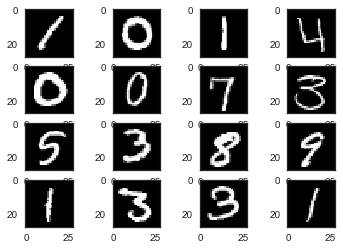

In [182]:
for digits in range(0,16):
    pixels = train[digits:digits+1]
    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape((28,28))
    plt.subplot(4,4,digits+1)
    plt.imshow(pixels, cmap='gray')

Next we need to ensure that the number of occurences of each value is relatively similar, as shown in the plot below. we can also check for any missing values in the dataset.

count       784
unique        1
top       False
freq        784
dtype: object

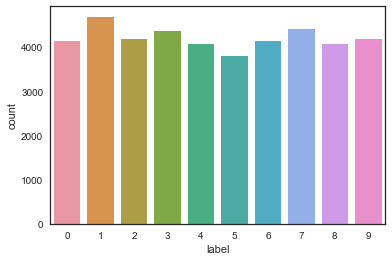

In [183]:
g = sns.countplot(labels)

# Check the data for missing values
train.isnull().any().describe()

The neural network will converge faster on normalized data, so below the data is normalized in the range 0-1.

In [184]:
# Normalize the data
train = train / 255.0
test_data = test_data / 255.0

The data can now be reshaped into 28x28x1 3D matrices.

In [185]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
train = train.values.reshape(-1,28,28,1)

In [186]:
# Split the train and the validation set for the fitting
X_train, X_eval, Y_train, Y_eval = train_test_split(train, labels, test_size = 0.1, random_state=5)

Building the neural net, a brief overview:

1) Using the Sequential model for a linear stack of layers

2) Add two convolution layers to extract high level information from the images. These will transform segments of the image defined by the kernel size and deduce which segments are the most important for this classification. An activation filter using ReLU will determine whether the neuron 'fires' i.e whether it outputs a value other than zero.

3) Max-pooling is then used to reduce computation time and decrease overfitting by taking the largest value from a 2x2 square of the convolution layer outputs and disregarding the rest, this effectively summarizes the data from the previous layers.

4) Dropout is used to randomly turn off some number of neurons in the layers in order to reduce overfitting.

5) More convolution layers, this time with double the filters in order to find different/deeper details missed by the early layers.

6) Max-pooling and dropout repeated for the same reasons as above.

7) Keras requires that a 3D matrix is inputed but dense layers require a 1D vector to make use of the fully connected layers, so this returns the data in 1D.

8) Dense is a fully connected neural network layer, using activation this summarizes the most important information about the images we wish to classify

9) Dropout is used here for the same reason as above.

10) The output layer is reduced to 10 to coincide with the 10 outputs we wish to classify to.

In [187]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Optimizers are methods which allow the neural net to identify features that cause the classification to be incorrect and so adjusts the rate at which the feature weights are changed to more quickly and effectively converge to a more correct solution.

In [188]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

Compiling the model simply puts all the added layers into place ready for training, the scoring metrics are also defined here.

In [189]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

The learning rate annealer will reduce the learning rate once a metric has stopped improving over the course of 'patience' number of epocks, this is important when using a larger number of epochs and can allow further optimization of the model.

In [190]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
#Setting variables for the .fit method
#Increase epochs to increase final accuracy, increases compute time vastly!
epochs = 2 
batch_size = 86
#Converting labels (Y_train) to categorical data for use in the fit.
Y_train = to_categorical(Y_train, 10)
Y_eval_cat = to_categorical(Y_eval, 10)

In [191]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_eval, Y_eval_cat), verbose = 2, callbacks=[learning_rate_reduction])

Train on 37800 samples, validate on 4200 samples
Epoch 1/2
 - 240s - loss: 0.2418 - acc: 0.9239 - val_loss: 0.0677 - val_acc: 0.9764
Epoch 2/2
 - 177s - loss: 0.0738 - acc: 0.9782 - val_loss: 0.0396 - val_acc: 0.9888


In [192]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
prediction = model.predict(X_eval)
prediction = argmax(prediction, axis=1)
score = accuracy_score(Y_eval, prediction)
print(score)

0.9888095238095238


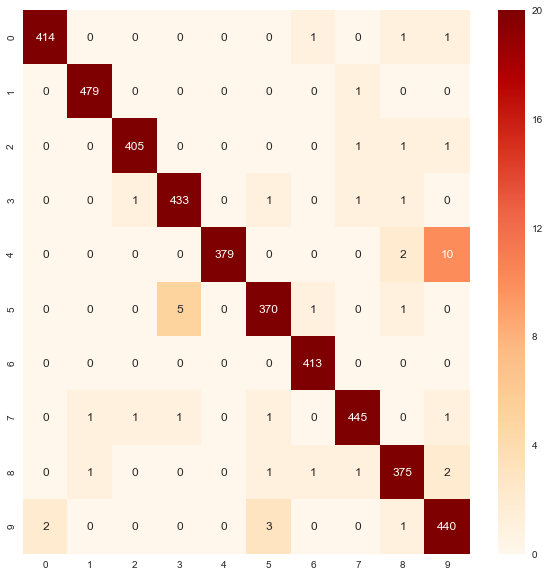

In [193]:
cm = confusion_matrix(Y_eval, prediction)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, vmin = 0, vmax = 20, fmt = "d", cmap="OrRd", yticklabels=True)

Another way to prevent overfitting is to augment the data with random small variation as done below:

In [197]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [198]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_eval,Y_eval_cat),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/2
 - 178s - loss: 0.0780 - acc: 0.9769 - val_loss: 0.0515 - val_acc: 0.9855
Epoch 2/2
 - 178s - loss: 0.0714 - acc: 0.9795 - val_loss: 0.0358 - val_acc: 0.9914


0.9914285714285714


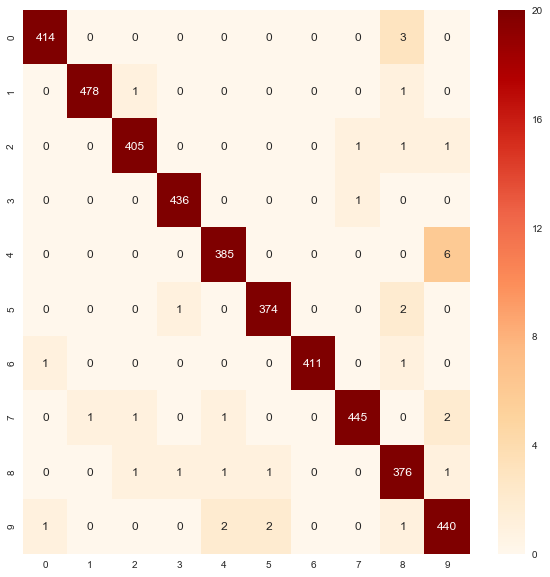

In [199]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
prediction = model.predict(X_eval)
prediction = argmax(prediction, axis=1)
score = accuracy_score(Y_eval, prediction)
print(score)

cm = confusion_matrix(Y_eval, prediction)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, vmin = 0, vmax = 20, fmt = "d", cmap="OrRd", yticklabels=True)

An impressive score for a fairly simple CNN set up.